In [1]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, linewidth=0.5, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class EfficientSelfAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads,
        reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride = reduction_ratio, bias = False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias = False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h = heads, x = h, y = w)
        return self.to_out(out)

class MixFeedForward(nn.Module):
    def __init__(
        self,
        *,
        dim,
        expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)


## 컨볼루션 임베딩
class Embedding(nn.Module):
    def __init__(self, dim_in,dim_out, kernel_size, stride, padding):
        super(Embedding, self).__init__()
        self.embedding = nn.Conv2d(dim_in, 
                                   dim_out, 
                                   kernel_size=kernel_size, 
                                   stride=stride, 
                                   padding=padding)
        
    def forward(self, x):
        return self.embedding(x)
    
'''
5. MiT (Mixer Transformer)
이미지를 여러 스테이지로 처리합니다. 각 스테이지는 이미지를 패치로 나누고, 패치를 임베딩한 후, 여러 개의 Transformer 레이어를 적용합니다.
이 과정은 이미지의 다양한 해상도에서 특징을 추출합니다. 
'''    
class MiT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        dims,
        heads,
        ff_expansion,
        reduction_ratio,
        num_layers,
        stage_kernel_stride_pad = ((7, 4, 3),  
                                   (3, 2, 1), 
                                   (3, 2, 1), 
                                   (3, 2, 1))
    ):
        super().__init__()


        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(
            dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            #여기서 너비와 높이가 같은 정사각형 패치를 사용합니다.
            get_overlap_patches = nn.Unfold(kernel, stride = stride, padding = padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim = dim_out, heads = heads, reduction_ratio = reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim = dim_out, expansion_factor = ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
        self,
        x,
        return_layer_outputs = False
    ):
        h, w = x.shape[-2:]
        
        
        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)
            
            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            
            x = rearrange(x, 'b c (h w) -> b c h w', h = h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret
    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , dim, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

'''
6. Segformer
MiT를 통해 추출된 여러 스케일의 특징을 결합하고, 최종적으로 세그멘테이션 맵을 생성합니다.
각 스테이지의 출력을 디코더 차원으로 매핑하고, 업샘플링하여 동일한 해상도로 만든 후, 이를 결합합니다.
결합된 특징 맵을 사용하여 최종 세그멘테이션 맵을 생성합니다.
'''
class ARC_Net(nn.Module):
    def __init__(
        self,
        *,
        dims=(32, 64, 160, 256),
        heads=(1, 2, 5, 8),
        ff_expansion=(8, 8, 4, 4),
        reduction_ratio=(8, 4, 2, 1),
        num_layers=2,
        channels=1,
        num_classes=11,
        kernel_stride_paddings = ((1, 1, 0),(3, 2, 1), (3, 2, 1), (3, 2, 1))
    ):
        super().__init__()
        decoder_dim = dims[-1]
        
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=len(kernel_stride_paddings)), (dims, heads, ff_expansion, reduction_ratio, num_layers))

        
        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers,
            stage_kernel_stride_pad=kernel_stride_paddings
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor=2 ** i)
        ) for i, dim in enumerate(dims)])


        
        self.cbam = CBAM(gate_channels = decoder_dim * len(kernel_stride_paddings) * 2)  
        
        self.reduce = nn.Conv2d(decoder_dim * len(dims) * 2, decoder_dim * len(dims), 1)        
        
        self.to_segmentation = Head(decoder_dim*len(dims) * 3, decoder_dim*len(dims) , num_classes)
        
    def _fusion(self, x):
        x = self.mit(x, return_layer_outputs=True)
        fused = []
        for output, to_fused in zip(x, self.to_fused):
            x = to_fused(output)  # Conv2d 적용
            # 업샘플링하여 공간 크기를 맞춥니다.
            fused.append(x)
        fused = torch.cat(fused, dim=1)
        return fused    
    
    def forward(self, x, ex_inputs, ex_outputs):
        x = self._fusion(x) # [b,1,H,W] -> [b,dim_0,H,W],...,[b,dim_n, H//(n+1), W//(n+1)] 
                            # -> [b,dim_n, H, W],...,[b,dim_n, H, W] -> [b, dim_n * 2, H, W]
                            # [b, 256, 32, 32]
                            
        # 예제 입력과 출력을 채널 차원으로 분할
        n_examples = ex_inputs.size(1)  # n_examples * channels (여기서는 3)
        
        # 예제 수만큼 반복하면서 예제 입력과 출력을 처리
        fused = []
        for i in range(n_examples):
            ex_i = ex_inputs[:, i:i+1, :, :]  # [batch_size, 1, H, W]
            ex_o = ex_outputs[:, i:i+1, :, :]  # [batch_size, 1, H, W]
            
            ex_i = self._fusion(ex_i)
            ex_o = self._fusion(ex_o)
            
            ex_f = torch.cat([ex_i, ex_o], dim=1)
            ex_f = self.cbam(ex_f)
            ex_f = self.reduce(ex_f)
            fused.append(ex_f)
        
        for i, ex_f in enumerate(fused):
            ex_f = torch.cat([x, ex_f], dim=1)
            ex_f = self.cbam(ex_f)
            ex_f = self.reduce(ex_f)
            fused[i] = ex_f
        
        fused = torch.cat(fused, dim=1)
        output = self.to_segmentation(fused)
        
        return output

In [4]:
# 모델 생성 및 출력
model_args = {
    'dims': (64, 128),
    'heads': 4,
    'ff_expansion': 4,
    'reduction_ratio': 2,
    'num_layers': 4,
    'channels': 1,
    'num_classes': 11,
    'kernel_stride_paddings': ((1, 1, 0),(3, 2, 1))
    }

In [5]:
# dims, heads, ff_expansion, reduction_ratio, num_layers = map(
#             partial(cast_tuple, depth=4), (model_args['dims'], 
#                                            model_args['heads'], 
#                                            model_args['ff_expansion'], 
#                                            model_args['reduction_ratio'], 
#                                            model_args['num_layers']))
# mit = MiT(
#         dims=dims,
#         heads=heads,
#         ff_expansion=ff_expansion,
#         reduction_ratio=reduction_ratio,
#         num_layers=num_layers,
#         channels=model_args['channels'],
#         stage_kernel_stride_pad=model_args['kernel_stride_paddings'],
        
#           )
# x = torch.randn(10, 1, 30, 30)

# print("Input shape:", x.shape)
# x = mit(x,return_layer_outputs = True)

# print("Output shape:", x[0].shape)
# print("Output shape:", x[1].shape)

In [6]:
# x1 = x[0] + x[0]
# x1.shape

In [7]:
fuse = [torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32)]

x= torch.randn(10, 256, 32, 32)
for i , ex in enumerate(fuse) :
    print("fuse shape:", ex.shape)
    ex = torch.cat([ex, x], dim=1)
    print("fuse shape:", ex.shape)
    fuse[i] = ex
    print("fuse shape:", fuse[i].shape)
    print("==================")

fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 256, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])
fuse shape: torch.Size([10, 512, 32, 32])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 1, 32, 32).to(device)
e_i, e_o = torch.randn(10, 3, 32, 32).to(device), torch.randn(10, 3, 32, 32).to(device)
print(model(x,e_i,e_o).shape)

torch.Size([10, 11, 32, 32])


In [9]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = ARC_Net(**model_args).to(device)



from torchinfo import summary

summary(outer_model, input_size=((1, 1, 30, 30), (1, 3, 30, 30), (1, 3, 30, 30)))

Layer (type:depth-idx)                                                 Output Shape              Param #
ARC_Net                                                                [1, 11, 30, 30]           --
├─MiT: 1-1                                                             [1, 64, 30, 30]           --
│    └─ModuleList: 2-23                                                --                        (recursive)
│    │    └─ModuleList: 3-45                                           --                        (recursive)
│    │    └─ModuleList: 3-46                                           --                        (recursive)
├─ModuleList: 1-18                                                     --                        (recursive)
│    └─Sequential: 2-2                                                 [1, 128, 30, 30]          --
│    │    └─Conv2d: 3-3                                                [1, 128, 30, 30]          8,320
│    │    └─Upsample: 3-4                               

In [10]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [11]:
import torch
#weight = torch.ones(11).to('cuda')
#weight[0] = 0.0005  # 0은 무시
#print(weight)

In [12]:
import numpy as np
import os
import torch.optim as optim
from torch import nn
from copy import deepcopy
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
from itertools import combinations

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data
import random
from itertools import combinations

class ARC_Dataset(Dataset):
    def __init__(self, challenges, solution, task_data_num=1, example_data_num=3, max_combinations=10):
        challenges = load_json(challenges)
        solution = load_json(solution)
        self.data = []
        self.task_data_num = task_data_num
        self.example_data_num = example_data_num
        self.max_combinations = max_combinations

        for key, value in challenges.items():
            for i in range(len(value['test'])):
                task_input = value['test'][i]['input']
                task_output = solution[key][i]
                example_list = value['train'].copy()

                n_examples = len(example_list)  # 원래 예제의 개수

                # 예제 수가 example_data_num보다 적으면 현재 작업의 예제를 복제하여 채움
                if n_examples < self.example_data_num:
                    while len(example_list) < self.example_data_num:
                        example_list.append(random.choice(example_list))

                    # 조합은 예제 리스트 자체로 설정
                    ex_combinations = [tuple(example_list)]
                else:
                    # 예제의 조합 생성
                    ex_combinations = list(combinations(example_list, self.example_data_num))

                    # 조합의 수를 제한
                    if len(ex_combinations) > self.max_combinations:
                        ex_combinations = random.sample(ex_combinations, self.max_combinations)

                for ex_combo in ex_combinations:
                    ex_input = [ex['input'] for ex in ex_combo]
                    ex_output = [ex['output'] for ex in ex_combo]

                    # 데이터에 추가하면서 원래 예제의 개수도 포함
                    self.data.append({
                        'id': key,
                        'input': task_input,
                        'output': task_output,
                        'ex_input': ex_input,
                        'ex_output': ex_output,
                        'num_original_examples': n_examples  # 원래 예제 개수 추가
                    })

        # 리스트를 데이터프레임으로 변환
        self.df = pd.DataFrame(self.data)
        
    def __len__(self):
        return len(self.df)
    
    def pad_to_32x32(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 32 - h)
        pad_w = max(0, 32 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor
    
    def pad_to_30x30(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 30 - h)
        pad_w = max(0, 30 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor

    def mapping_input(self, tensor):
        mapping = {
            1: random.randint(1, 10),
            2: random.randint(11, 20),
            3: random.randint(21, 30),
            4: random.randint(31, 40),
            5: random.randint(41, 50),
            6: random.randint(51, 60),
            7: random.randint(61, 70),
            8: random.randint(71, 80),
            9: random.randint(81, 90),
            10: random.randint(91, 100)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def noise_input(self, tensor):
        mapping = {
            1: 1+ np.random.normal(0, 1),
            2: 2+ np.random.normal(0, 1),
            3: 3+ np.random.normal(0, 1),
            4: 4+ np.random.normal(0, 1),
            5: 5+ np.random.normal(0, 1),
            6: 6+ np.random.normal(0, 1),
            7: 7+ np.random.normal(0, 1),
            8: 8+ np.random.normal(0, 1),
            9: 9+ np.random.normal(0, 1),
            10: 10+ np.random.normal(0, 1)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor
    
    def augment_example_output(self, tensor):
        # 출력 데이터 증강 (아직 구현 필요)
        return tensor

    def __getitem__(self, idx):
        task = self.df.iloc[idx]
        
        # task_input과 task_output 변환 및 패딩 추가
        task_input = self.pad_to_32x32((torch.tensor(task['input'], dtype=torch.float32) + 1))
        task_output = self.pad_to_32x32((torch.tensor(task['output'], dtype=torch.float32) + 1))
        
        # 입력 채널 차원 추가
        if task_input.dim() == 2:
            task_input = task_input.unsqueeze(0)  # [1, H, W]
        if task_output.dim() == 2:
            task_output = task_output.unsqueeze(0)  # [1, H, W]
        
        # 예제 입력과 출력 변환 및 패딩 추가
        example_input = []
        example_output = []
        for ex_in, ex_out in zip(task['ex_input'], task['ex_output']):
            ex_in_tensor = self.pad_to_32x32(torch.tensor(ex_in, dtype=torch.float32) + 1)
            ex_out_tensor = self.pad_to_32x32(torch.tensor(ex_out, dtype=torch.float32) + 1)
            
            # 입력 채널 차원 추가
            if ex_in_tensor.dim() == 2:
                ex_in_tensor = ex_in_tensor.unsqueeze(0)  # [1, H, W]
            if ex_out_tensor.dim() == 2:
                ex_out_tensor = ex_out_tensor.unsqueeze(0)  # [1, H, W]
            
            example_input.append(ex_in_tensor)
            example_output.append(ex_out_tensor)
        
        # 예제 입력과 출력을 채널 차원으로 결합
        ex_inputs = torch.cat(example_input, dim=0)  # [n_examples * channels, H, W]
        ex_outputs = torch.cat(example_output, dim=0)  # [n_examples * channels, H, W]
        
        return task_input, task_output, ex_inputs, ex_outputs

# 사용 예제
train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

ti, to, ei, eo = next(iter(train_loader))
print(ti.shape, to.shape, ei.shape, eo.shape)

torch.Size([10, 1, 32, 32]) torch.Size([10, 1, 32, 32]) torch.Size([10, 3, 32, 32]) torch.Size([10, 3, 32, 32])


Using cuda device


Epoch 1/1000:   0%|          | 0/51 [00:00<?, ?it/s]

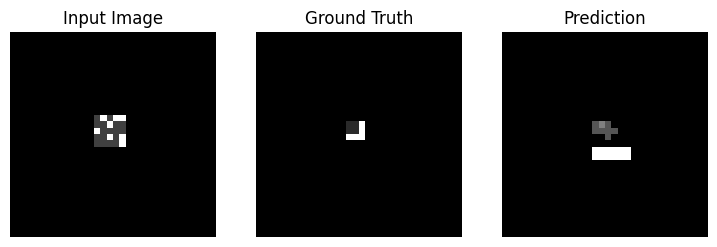

Epoch 1/1000:  78%|███████▊  | 40/51 [00:20<00:05,  2.03it/s, loss=1.2430]

In [13]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

train_args = {
    'challenges': train_challenge,
    'solution': train_solution,
    'num_classes': 11,
    'batch_size': 20,
    'epochs': 1000,
    'learning_rate': 0.001,
}

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    # print(y_pred.shape, y.shape)
    weight = torch.ones(train_args['num_classes']).to(y.device)
    weight[0] = 0.05
    # weight[1] = 0.5
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

def calculate_accuracy(predictions, targets, mask=None):
    pred_classes = predictions.argmax(dim=1)  # [batch_size, H, W]
    targets = targets.squeeze(1)  # [batch_size, H, W]

    total_samples = targets.size(0)
    correct_samples = pred_classes.eq(targets).all(dim=(1, 2)).sum().item()

    if mask is not None:
        correct_pixels = ((pred_classes == targets) & mask).sum().item()
        total_pixels = mask.sum().item()
    else:
        correct_pixels = pred_classes.eq(targets).sum().item()
        total_pixels = targets.numel()

    # 디버깅을 위한 출력
    # print(f"correct_samples: {correct_samples}, total_samples: {total_samples}")
    # print(f"correct_pixels: {correct_pixels}, total_pixels: {total_pixels}")

    return correct_samples, total_samples, correct_pixels, total_pixels

def visualize_predictions(inputs, targets, predictions, condition):
    if condition:
        # 입력 이미지와 예측 결과를 CPU로 이동
        inputs = inputs.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # 첫 번째 배치의 첫 번째 이미지를 시각화
        input_image = inputs[0]            # shape: (C, H, W)
        target_image = targets[0]          # shape: (C, H, W) 또는 (H, W)
        prediction_image = predictions.argmax(dim=1)[0]  # shape: (H, W)

        # 입력 이미지 형태 조정
        if input_image.shape[0] == 1:
            # 채널 차원이 1인 경우, 채널 차원 제거
            input_image = input_image.squeeze(0)  # shape: (H, W)
        else:
            # 채널 차원이 3인 경우 (RGB 이미지)
            input_image = input_image.permute(1, 2, 0)  # shape: (H, W, C)

        # 타겟 이미지 형태 조정
        if target_image.dim() == 3 and target_image.shape[0] == 1:
            target_image = target_image.squeeze(0)  # shape: (H, W)

        # 시각화를 위한 플롯 생성
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))

        # 입력 이미지 표시
        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        # 타겟 이미지 표시
        axes[1].imshow(target_image, cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        # 예측 결과 표시
        axes[2].imshow(prediction_image, cmap='gray')
        axes[2].set_title('Prediction')
        axes[2].axis('off')

        plt.show()



# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

# 데이터셋 및 데이터로더 생성
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=train_args['batch_size'], shuffle=True)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=train_args['batch_size'], shuffle=False)

# 모델 정의
model = ARC_Net(**model_args).to(device)

# 옵티마이저 정의
optimizer = optim.AdamW(model.parameters(), lr=train_args['learning_rate'])

def train(epoch):
    model.train()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{train_args["epochs"]}', leave=False)

    for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
        task_inputs = task_inputs.to(device, non_blocking=True)
        task_outputs = task_outputs.to(device, non_blocking=True)
        ex_inputs = ex_inputs.to(device, non_blocking=True)
        ex_outputs = ex_outputs.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(task_inputs, ex_inputs, ex_outputs)

        # 손실 함수 계산
        loss = criterion(output, task_outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 정확도 계산
        correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs)
        total_correct_samples += correct_samples
        total_samples += batch_total_samples
        total_correct_pixels += correct_pixels
        total_pixels += batch_total_pixels

        # 특정 조건에서 시각화
        if batch_idx == 0:
            visualize_predictions(task_inputs, task_outputs, output, condition=True)
        
        # 프로그레스 바 업데이트
        progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    # 에포크가 끝난 후
    avg_sample_accuracy = 100. * total_correct_samples / total_samples
    avg_pixel_accuracy = 100. * total_correct_pixels / total_pixels
    avg_loss = total_loss / len(train_loader)

    print(f'\nEpoch [{epoch+1}/{train_args["epochs"]}] Complete')
    print(f'Average Loss: {avg_loss:.6f}')
    print(f'Training Sample Accuracy: {avg_sample_accuracy:.2f}%')
    print(f'Training Pixel Accuracy: {avg_pixel_accuracy:.2f}%\n')



def test():
    model.eval()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader), desc='Testing', leave=False)

    with torch.no_grad():
        for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
            task_inputs = task_inputs.to(device, non_blocking=True)
            task_outputs = task_outputs.to(device, non_blocking=True)
            ex_inputs = ex_inputs.to(device, non_blocking=True)
            ex_outputs = ex_outputs.to(device, non_blocking=True)

            output = model(task_inputs, ex_inputs, ex_outputs)

            # 손실 함수 계산
            loss = criterion(output, task_outputs)
            total_loss += loss.item()

            # 정확도 계산
            correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs)
            total_correct_samples += correct_samples
            total_samples += batch_total_samples
            total_correct_pixels += correct_pixels
            total_pixels += batch_total_pixels

            # 특정 조건에서 시각화
            if batch_idx == 0:
                visualize_predictions(task_inputs, task_outputs, output, condition=True)
            # 프로그레스 바 업데이트
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    avg_sample_accuracy = 100. * total_correct_samples / total_samples
    avg_pixel_accuracy = 100. * total_correct_pixels / total_pixels
    avg_loss = total_loss / len(eval_loader)

    print(f'Test Average Loss: {avg_loss:.6f}')
    print(f'Test Sample Accuracy: {avg_sample_accuracy:.2f}%')
    print(f'Test Pixel Accuracy: {avg_pixel_accuracy:.2f}%\n')


# 학습 실행
for epoch in range(train_args['epochs']):  
    train(epoch)
    test()